In [82]:
#Libraries 
#pip install 'gymnasium[box2d]' pygame matplotlib box2d
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import utils
import time
import random
import tensorflow as tf
from collections import deque,namedtuple
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [83]:
#Creating env 
env = gym.make("LunarLander-v3", render_mode="rgb_array")

In [84]:
#Adding seed so it always stays same
env.action_space.seed(42)

42

In [85]:
# Observation space
print("Observation space:", env.observation_space)
print("Shape of state vector:", env.observation_space.shape)

Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Shape of state vector: (8,)


In [86]:
# Print example states
print("\nExample state samples:")
for _ in range(3):
    print(env.observation_space.sample())


Example state samples:
[ 1.637271   -2.4471097   7.5318666  -4.6255717   2.5499399  -7.174191
  0.46930605  0.7356477 ]
[-1.1321975  -0.03778353  5.10391     4.504031   -0.6086102  -4.9489083
  0.54902935  0.09743079]
[ 1.3587545  -2.19647    -3.5265596   8.555613    4.780393    7.4778743
  0.84913933  0.7468765 ]


In [87]:

# Action space
print("\nAction space:", env.action_space)
print("Number of discrete actions:", env.action_space.n)


Action space: Discrete(4)
Number of discrete actions: 4


In [88]:
# Print all possible actions
print("\nAll possible actions:")
for a in range(env.action_space.n):
    print(f"Action {a}")



All possible actions:
Action 0
Action 1
Action 2
Action 3


In [89]:

# Reset the environment and get the initial state.
current_state = env.reset()

# Select an action
action = 0

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, terminated, truncated, info = env.step(action)
done = terminated or truncated

print(f"{'Current State:':<15} {current_state}")
print(f"{'Action Taken:':<15} {action}")
print(f"{'Next State:':<15} {next_state}")
print(f"{'Reward:':<15} {reward}")
print(f"{'Done:':<15} {done}")


# Replace the `current_state` with the state after the action is taken
current_state = next_state

Current State:  (array([ 0.00668516,  1.4059547 ,  0.6771059 , -0.2207006 , -0.00773952,
       -0.1533747 ,  0.        ,  0.        ], dtype=float32), {})
Action Taken:   0
Next State:     [ 0.01337042  1.4004129   0.67619085 -0.246358   -0.01531846 -0.15159261
  0.          0.        ]
Reward:         -0.9589541430042061
Done:           False


## Implementing Q learning


In [90]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

In [91]:
# records the current time to later compute how long training took.
start = time.time()

In [92]:

#Total number of episodes (training iterations).
#Each episode represents a full run from initial state to terminal state (or until the timestep limit).
#The agent learns from each episode.
num_episodes = 2000

#Maximum steps allowed per episode.
#Prevents infinite loops in non-terminal environments.
max_num_timesteps = 500

#Stores the cumulative reward (or "points") obtained in each episode.
total_point_history = []

#Used to compute a moving average of the total points over the last 10 episodes.
num_p_av = 100    # number of total points to use for averaging

#With probability ε, choose a random action (exploration).
#With probability 1-ε, choose the best known action (exploitation).
epsilon = 1.0     # initial ε value for ε-greedy policy

#Batch size for implementing minibatch 
batch_size = 64

#Keras learning rate Adam 
ALPHA = 0.01
min_epsilon = 0.01
epsilon_decay = 0.995
gamma = 0.99 
tau = 0.005

In [93]:
from tensorflow.keras.models import Sequential

In [94]:
#1 Initialize memory buffer D with capacity N
memory_length = 1000
#N = capacity of the buffer, i.e., how many experiences it can store.
#deque comes from Python’s collections module: from collections import deque.
#It's a data structure like a list but optimized for fast appends and pops from both ends.
#Think of it as a queue with automatic memory management when a max length is set.
memory_buffer = deque(maxlen=memory_length)


#2 Initialize Q-Network with random weights w
q_network = Sequential([ 
    tf.keras.layers.Dense(24, activation='relu',input_shape=(state_size)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(units=num_actions, activation='linear') 
    ])


#3 Initialize target Q-Network with weights w = w
target_q_network = Sequential([ 
    tf.keras.layers.Dense(24, activation='relu',input_shape=(state_size)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(units=num_actions, activation='linear') 
    ])

#Making both network weight same 
target_q_network.set_weights(q_network.get_weights())

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

/Users/pingle/Desktop/Coding/Qlearning/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [95]:
#4 for episode i = 1 to M do
for i in range(num_episodes):
    #5 Receive initial observation state S ₁
    # Reset the environment and get the initial state.
    state,_ = env.reset()
    total_points = 0 
    
    #for t=1 to T do Observe state St and choose action At using an e-greedy policy
    for t in range(max_num_timesteps):
        #creating a state_qn from state dimensions
        state_qn = np.expand_dims(state, axis=0)
        
        '''
        Passes the (expanded) state through the Q-network.

        The Q-network predicts Q-values for all possible actions from this state.

        Output is typically a 1D array: e.g. [Q(s,a₀), Q(s,a₁), ..., Q(s,aₙ)]
        '''
        q_values = q_network(state_qn)

        #Choose an action using ε-greedy strategy.
        if random.random() > epsilon:
            action= np.argmax(q_values.numpy()[0])
        else:
            action=random.choice(np.arange(4))
        
        #Take action At in the environment , receive reward Rt and next state St+1
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        
        #Store experience tuple ( St , At , Rt , St+1 ) in memory buffer D
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        #Every C steps perform a learning update :
        if len(memory_buffer) >= batch_size and t%num_p_av==0:
            
            #Sample random mini-batch of experience tuples ( Sj , Aj , Rj , Sj+1 ) from D
            mini_batch = random.sample(list(memory_buffer),batch_size)
            
            #unpacking all the things 
            states = np.array([exp.state for exp in mini_batch])
            actions = np.array([exp.action for exp in mini_batch])
            rewards = np.array([exp.reward for exp in mini_batch])
            next_states = np.array([exp.next_state for exp in mini_batch])
            done_vals = np.array([exp.done for exp in mini_batch])
            
            
            #Performing Gradient update
            with tf.GradientTape() as tape:
                #reshape y_targets 
                q_values = q_network(states)
                q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                            tf.cast(actions, tf.int32)], axis=1))
                
            
                #Set yj = R ; if episode terminates at step j + 1 , otherwise set yj = R + maxa ' Q(sj+1 , α ' )
                max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
                y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
            
            
            
                #loss 
                loss = MSE(y_targets,q_values)
            
            # Perform a gradient descent step on ( yjQ(sj , aj ; w))2 with respect to the Q-Network weights w
            # Get the gradients of the loss with respect to the weights.
            gradients = tape.gradient(loss, q_network.trainable_variables)
            
            # Update the weights of the q_network.
            optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))
            
            #Update the weights of the Q-Network using a soft update
            # w_target = (tau*w) + (1-tau)*w_target
            for target_weights, q_net_weights in zip(target_q_network.weights, q_network.weights):
                target_weights.assign(tau * q_net_weights + (1.0 - tau) * target_weights)

        #Decay episolon 
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        
        
        state = next_state.copy()
        total_points += reward
        
        #adding total reward into our main history list
        total_point_history.append(total_points)
        
        # Print episode summary
        if i % 10 == 0:
            avg_points = np.mean(total_point_history[-num_p_av:])
            print(f"Episode {i}, Total Points: {total_points}, Avg Points: {avg_points:.2f}, Epsilon: {epsilon:.3f}")



Episode 0, Total Points: -1.0321378440940805, Avg Points: -1.03, Epsilon: 0.995
Episode 0, Total Points: -3.5490433313763945, Avg Points: -2.29, Epsilon: 0.990
Episode 0, Total Points: -4.980854113354551, Avg Points: -3.19, Epsilon: 0.985
Episode 0, Total Points: -7.533587060463272, Avg Points: -4.27, Epsilon: 0.980
Episode 0, Total Points: -10.16162761202798, Avg Points: -5.45, Epsilon: 0.975
Episode 0, Total Points: -13.303378058466869, Avg Points: -6.76, Epsilon: 0.970
Episode 0, Total Points: -15.38298826754177, Avg Points: -7.99, Epsilon: 0.966
Episode 0, Total Points: -18.757738608673655, Avg Points: -9.34, Epsilon: 0.961
Episode 0, Total Points: -20.29314444252625, Avg Points: -10.55, Epsilon: 0.956
Episode 0, Total Points: -21.568069334126385, Avg Points: -11.66, Epsilon: 0.951
Episode 0, Total Points: -22.8240039155313, Avg Points: -12.67, Epsilon: 0.946
Episode 0, Total Points: -23.883109285553154, Avg Points: -13.61, Epsilon: 0.942
Episode 0, Total Points: -24.54416273245151

In [96]:

# Print the Q-network weights to see the learned parameters
q_network_weights = q_network.get_weights()
for idx, layer_weights in enumerate(q_network_weights):
    print(f"Layer {idx + 1} weights:")
    print(layer_weights)
    print("----")


Layer 1 weights:
[[ 1.3353022e+00  8.8985401e-01 -2.3878622e-01 -5.9505504e-02
  -3.2948440e-01 -1.1526259e+00 -1.9297695e+00 -6.8874460e-01
   6.3873833e-01  1.4930938e+00  1.8103119e+00  2.0530206e-01
   1.4486398e-01 -1.7506382e+00 -2.1028535e+00 -9.7757256e-01
  -1.3055212e+00 -8.5379779e-01  9.0722895e-01  1.2342312e+00
  -1.1029133e+00 -1.2403515e-01 -4.5586354e-01 -4.9353886e-01]
 [ 5.4603241e-02  4.7954828e-01 -1.6267698e-02  9.3526214e-01
   2.6557353e-01  8.0047083e-01  1.1460663e+00  2.2363919e-01
  -2.4204911e-01  4.0066937e-01  9.4193375e-01  1.4406791e-01
   8.0523854e-01  1.9982562e+00  2.1972625e+00  1.1052674e+00
  -5.7969976e-02  1.0794798e+00  3.2197440e-01  5.9850156e-01
  -5.2951280e-02  5.9654556e-02  2.2516992e-02  8.3468312e-01]
 [-1.7360430e+01  2.4848046e+00  4.8205032e+00  7.5862414e-01
   1.3499519e+00  1.3833806e+01 -9.1693020e-01  1.3403831e+00
   3.9300747e-02 -1.0450582e+01 -1.5714217e+00  5.7867155e+00
   6.7589273e+00 -8.8477659e-01 -1.5108339e+00 -6.1

Text(0.5, 1.0, 'Avg. Training Score')

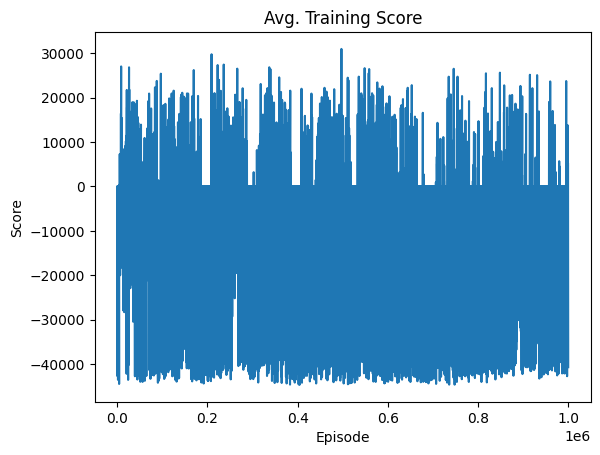

In [97]:
import pandas as pd
pd.Series(total_point_history).rolling(20).mean().plot()
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title("Avg. Training Score")